In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#import pandas_profiling as profile

# ETL -- Extract, Transform, Load processes

In [2]:
df=pd.read_csv('covid_19_data.csv', index_col=0)
ppl=pd.read_csv('population_by_country_2020.csv')

## Working on DF

In [3]:
df.Confirmed=df.Confirmed.astype(int)
df.Deaths=df.Deaths.astype(int)
df.Recovered=df.Recovered.astype(int)

In [4]:
df['Active']=df.Confirmed-df.Deaths-df.Recovered

In [5]:
print(df.shape)
print(df.index)
df.head()

(7926, 8)
Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926],
           dtype='int64', name='SNo', length=7926)


,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active
SNo,,,,,,,,
1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1,0,0,1
2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14,0,0,14
3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6,0,0,6
4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1,0,0,1
5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0,0,0,0


In [6]:
#profile.ProfileReport(df)

## this command uses Matplotlib using agg, which is a non-GUI backend, so cannot show following figures
# choose which to use before starting the analysis

### Null values and duplicates

In [7]:
df.isna().sum()

ObservationDate       0
Province/State     3433
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
Active                0
dtype: int64

In [8]:
df[df.duplicated()]

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active
SNo,,,,,,,,


- It seems that no duplicates are present. There are null values just in the province/state column, which means that not all the countries present differences in the territory

- drop Last Update (the last moment in which we had the updates)

- aggregate province and country

In [9]:
df['Province/State'].fillna('',inplace=True)
df.drop(['Last Update'],1,inplace=True)
#df.ObservationDate=pd.to_datetime(df.ObservationDate)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7926 entries, 1 to 7926
Data columns (total 7 columns):
ObservationDate    7926 non-null object
Province/State     7926 non-null object
Country/Region     7926 non-null object
Confirmed          7926 non-null int32
Deaths             7926 non-null int32
Recovered          7926 non-null int32
Active             7926 non-null int32
dtypes: int32(4), object(3)
memory usage: 371.5+ KB


## Working on Pop

https://www.kaggle.com/tanuprabhu/population-by-country-2020

this dataset contains data about world population. it is quite important to understand also how the population is structured in the country to better understand the spreadout of coronavirus

In [11]:
print(ppl.shape)
ppl.head()

(235, 11)


,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [12]:
ppl=ppl[['Country (or dependency)','Population (2020)','Density (P/Km²)','Med. Age','Urban Pop %']]
ppl.columns=['country','pop20','ppl_km','avg_age','urbanization']

In [13]:
ppl.head()

,country,pop20,ppl_km,avg_age,urbanization
0,China,1439323776,153,38,61%
1,India,1380004385,464,28,35%
2,United States,331002651,36,38,83%
3,Indonesia,273523615,151,30,56%
4,Pakistan,220892340,287,23,35%


In [14]:
ppl['country'].replace(['United States','United Kingdom','Czech Republic (Czechia)','State of Palestine'],
                       ['US','UK','Czech Republic','Palestine'],inplace=True)

In [15]:
ppl.urbanization = ppl.urbanization.str.rstrip('%')


# EDA -- Exploratory Data Analysis

# Covid Data

## Country

In [16]:
df=df.replace('None', '')
df.replace(to_replace='Mainland China',value='China', inplace=True)
df.replace("('St. Martin',)", 'St. Martin', inplace=True)
df.replace(" Azerbaijan", 'Azerbaijan', inplace=True)
df.replace("occupied Palestinian territory", 'Palestine', inplace=True)
df.replace(['The Gambia','Gambia, The','North Ireland','Republic of Ireland','Macau','Vatican City',
            'Saint Vincent and the Grenadines','Sao Tome and Principe','Curacao','East Timor','Ivory Coast','The Bahamas',
           'Bahamas, The','Cape Verde','Faroe Islands','Reunion','St. Martin'],
           ['Gambia','Gambia','Ireland','Ireland','Macao','Holy See','St. Vincent & Grenadines','Sao Tome & Principe',
           'Curaçao','Timor-Leste',"Côte d'Ivoire",'Bahamas','Bahamas','Cabo Verde','Faeroe Islands','Réunion',
           'Sint Maarten'],inplace=True)

## congo Kinshasa == Democratic republic of Congo
df.replace(["Congo (Kinshasa)",'Republic of the Congo'], ['DR Congo','DR Congo'], inplace=True)

## congo brazzaville (commonly known as Congo) is congo-brazzaville, different from previous congo Kinshasa
df.replace("Congo (Brazzaville)", 'Congo', inplace=True)

In [17]:
df.shape

(7926, 7)

## Province

In [18]:
new= df["Province/State"].str.split(",", n = 1, expand = True) 
new.columns=['country_city','prov']

new.replace([' IL',' MA',' CA',' WA',' AZ',' ON',' WI',' TX',' NE',' NE (From Diamond Princess)',
             ' CA (From Diamond Princess)',' TX (From Diamond Princess)',' QC',' OR',' RI',' NH',' FL',' NY',
            ' GA',' NC',' NJ',' NV',' TN',' MD',' CO',' Alberta',' PA',' KY',' IN',' MN',' CT',' SC',' UT',
            ' HI',' OR ',' OK',' VA',' D.C.',' KS',' MO',' VT',' IA',' LA', ' U.S.','US'],
            ['Illinois','Massachusetts','California','Washington','Arizona','Ontario','Wisconsin',
            'Texas','Nebraska','Nebraska','California','Texas','Quebec','Oregon','Rhode Island',
            'New Hampshire','Florida','New York','Georgia','North Carolina','New Jersey','Nevada',
            'Tennessee','Maryland','Colorado','Alberta','Pennsylvania','Kentucky','Indiana','Minnesota',
            'Connecticut','South Carolina','Utah','Hawaii','Oregon','Oklahoma','Virginia','District of Columbia',
            'Kansas','Missouri','Vermont','Iowa', 'Lousiana','United States','United States'], inplace=True)

  #print(new.iloc[:,1].unique())
  #print(new.prov.isna().sum())

#after splitting: US has province after comma, while china and the rest of the countries on before. put all province in the
#second col
new.prov.fillna(value=new.country_city,inplace=True)

df['Province']=new.country_city

### Aggregate province and state

In [19]:
df['country_province']=df['Country/Region']+'_'+df['Province']

In [20]:
df=df[['ObservationDate','Country/Region','Province/State','country_province','Confirmed','Deaths','Recovered','Active']]
df.columns=['date','country','prov_state','country_prov','confirmed','deaths','recovered','active']
df.replace('Others_Cruise Ship','Others_Diamond Princess cruise ship',inplace=True)

In [21]:
print(df.shape)
df.head()

(7926, 8)


,date,country,prov_state,country_prov,confirmed,deaths,recovered,active
SNo,,,,,,,,
1,01/22/2020,China,Anhui,China_Anhui,1,0,0,1
2,01/22/2020,China,Beijing,China_Beijing,14,0,0,14
3,01/22/2020,China,Chongqing,China_Chongqing,6,0,0,6
4,01/22/2020,China,Fujian,China_Fujian,1,0,0,1
5,01/22/2020,China,Gansu,China_Gansu,0,0,0,0


In [22]:
df.country_prov.unique()

array(['China_Anhui', 'China_Beijing', 'China_Chongqing', 'China_Fujian',
       'China_Gansu', 'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
       'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
       'Hong Kong_Hong Kong', 'China_Hubei', 'China_Hunan',
       'China_Inner Mongolia', 'China_Jiangsu', 'China_Jiangxi',
       'China_Jilin', 'China_Liaoning', 'Macao_Macao', 'China_Ningxia',
       'China_Qinghai', 'China_Shaanxi', 'China_Shandong',
       'China_Shanghai', 'China_Shanxi', 'China_Sichuan', 'Taiwan_Taiwan',
       'China_Tianjin', 'China_Tibet', 'US_Washington', 'China_Xinjiang',
       'China_Yunnan', 'China_Zhejiang', 'Japan_', 'Thailand_',
       'South Korea_', 'Singapore_', 'Philippines_', 'Malaysia_',
       'Vietnam_', 'Australia_', 'Mexico_', 'Brazil_', 'Colombia_',
       'US_Chicago', 'France_', 'US_Illinois', 'Nepal_', 'US_California',
       'US_Arizona', 'Canada_Ontario', 'Cambodia_', 'Sri Lanka_',
       "Côte d'Ivoire_", 'Austral

In [23]:
## Taking the maximum per each day
df_daymax=df.groupby(['date','country_prov','country']).max()
df_daymax.reset_index(inplace=True)
print(df_daymax.shape)
df_daymax.head()

(7882, 8)


,date,country_prov,country,prov_state,confirmed,deaths,recovered,active
0,01/22/2020,China_Anhui,China,Anhui,1,0,0,1
1,01/22/2020,China_Beijing,China,Beijing,14,0,0,14
2,01/22/2020,China_Chongqing,China,Chongqing,6,0,0,6
3,01/22/2020,China_Fujian,China,Fujian,1,0,0,1
4,01/22/2020,China_Gansu,China,Gansu,0,0,0,0


In [24]:
## summing for province -- getting totals for each country
df_countrymax=df_daymax.groupby(['date','country']).sum()
df_countrymax.reset_index(inplace=True)
print(df_countrymax.shape)
df_countrymax.head()

(3919, 6)


,date,country,confirmed,deaths,recovered,active
0,01/22/2020,China,547,17,28,502
1,01/22/2020,Hong Kong,0,0,0,0
2,01/22/2020,Japan,2,0,0,2
3,01/22/2020,Macao,1,0,0,1
4,01/22/2020,South Korea,1,0,0,1


### plot for each country

In [39]:
from datetime import datetime
import matplotlib.dates as mdates
def country_plot(df,title='ABC',x_size=20,y_size=6,save_fig=False,path=''):
    plt.figure(figsize=(x_size,y_size))

    x_values = df['date']
    y_values=df['confirmed']
    w_values=df['deaths']
    k_values=df['recovered']
    z_values=df['active']

    plt.plot(x_values,y_values, 'r-', label='Confirmed')
    plt.plot(x_values,z_values, 'g-',label='Carrier')
    plt.plot(x_values,w_values, 'b-',label='Deaths')
    plt.plot(x_values,k_values, 'y-',label='Recovered')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    if save_fig==True:
        plt.savefig(path+title+'-22mar20.png')
    return(plt.show())


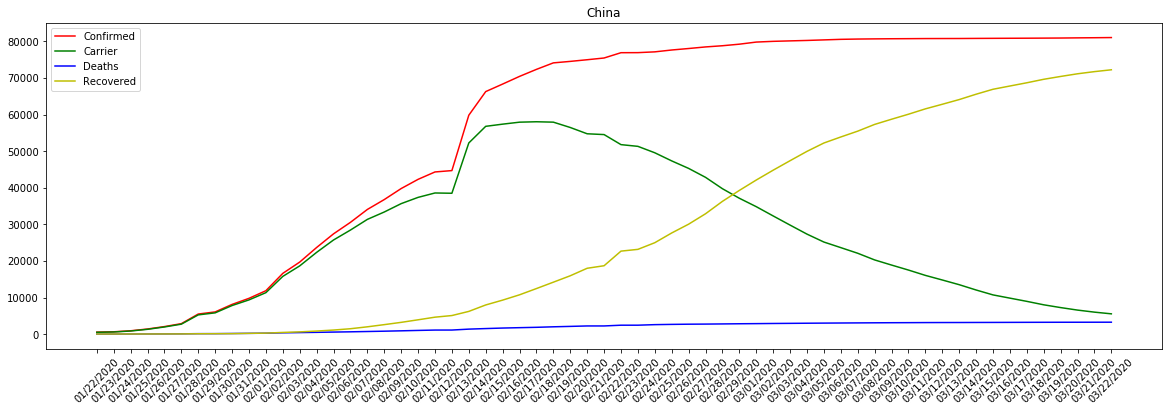

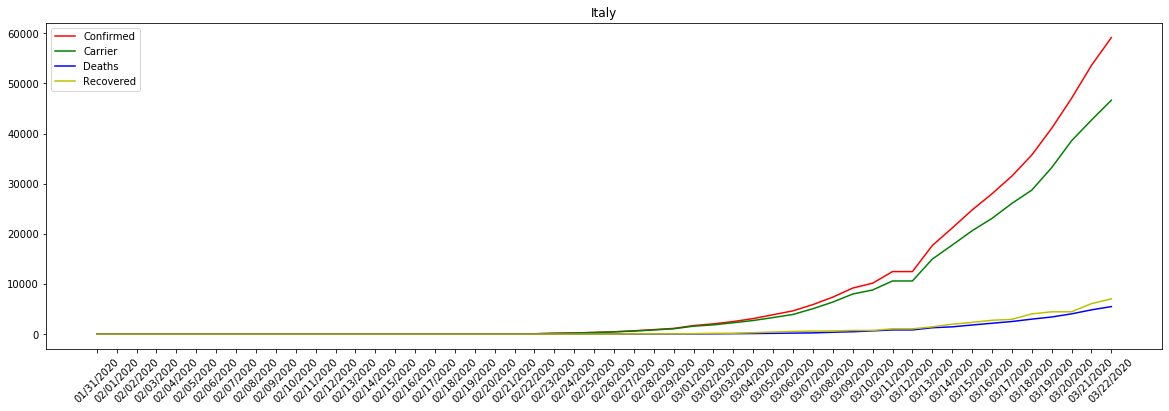

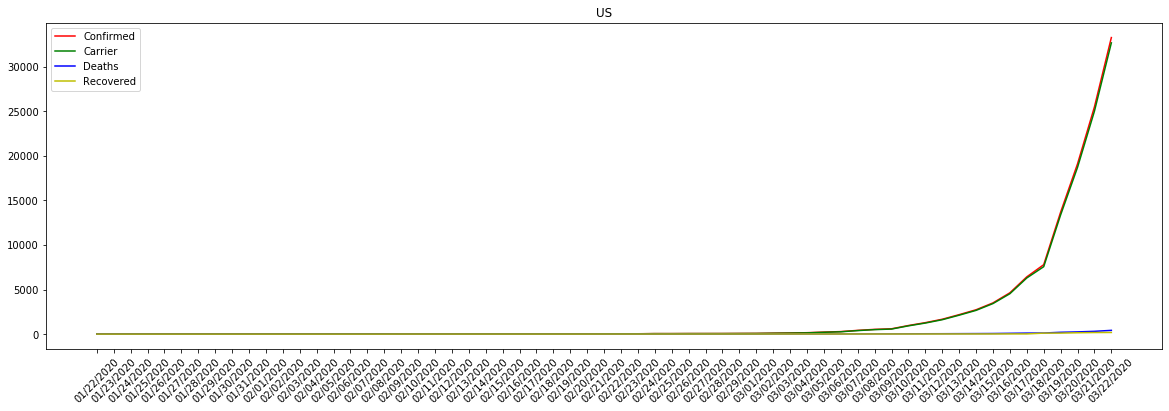

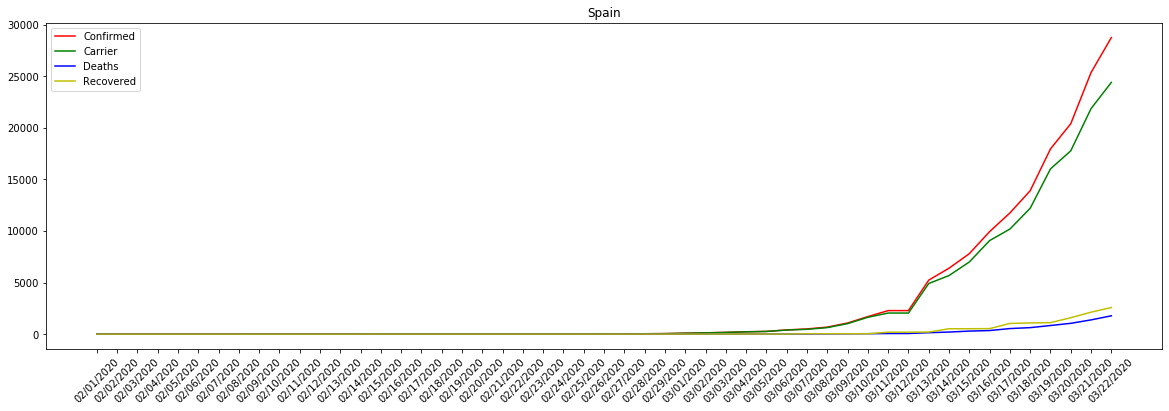

In [43]:
country_name=list(['China','Italy','US','Spain'])
for name in country_name:
    data=df_countrymax[df_countrymax['country']==name]
    country_plot(data,name,x_size=20,y_size=6,save_fig=True )
    #plt.savefig(name+'-targets plot.png')

### plot for world 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60],
 <a list of 61 Text xticklabel objects>)

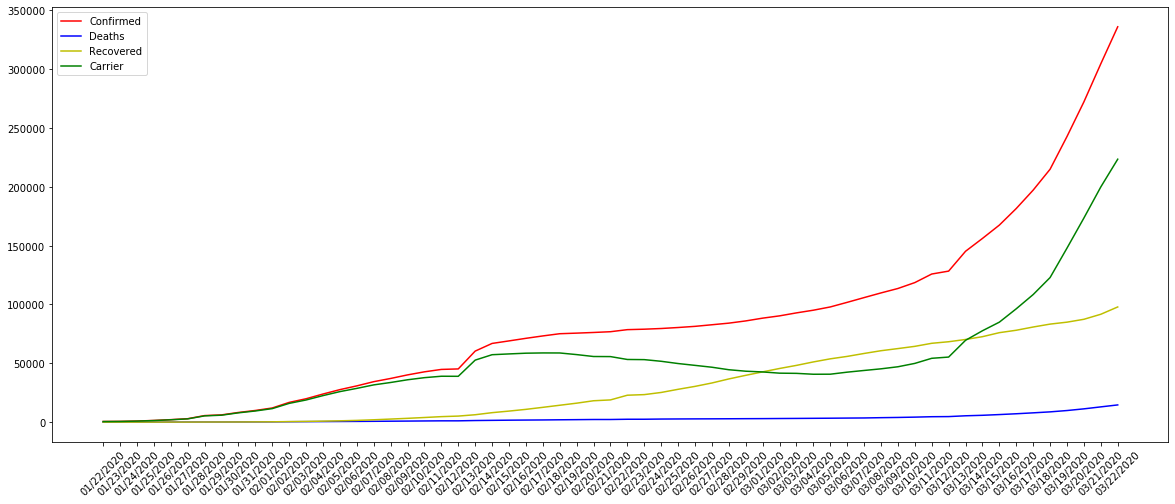

In [27]:
df_world=df_countrymax.groupby('date').sum()
df_world.reset_index(inplace=True)

x=df_world.date
k=df_world.active
z=df_world.deaths
w=df_world.recovered
y=df_world.confirmed

plt.figure(figsize=(20,8))
plt.plot(x,y, 'r-',label='Confirmed')
plt.plot(x,z,'b-', label='Deaths')
plt.plot(x,w,'y-', label='Recovered')
plt.plot(x,k,'g-', label='Carrier')
plt.legend()
plt.xticks(rotation=45)
#plt.savefig('world curves.png')

In [28]:
data=df

# World Population

In [29]:
ppl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 5 columns):
country         235 non-null object
pop20           235 non-null int64
ppl_km          235 non-null int64
avg_age         235 non-null object
urbanization    235 non-null object
dtypes: int64(2), object(3)
memory usage: 9.3+ KB


In [30]:
ppl.isna().sum()

country         0
pop20           0
ppl_km          0
avg_age         0
urbanization    0
dtype: int64

It seems that in average age the unknown average is actually written as N.A.; the same problem encoutered with urbanization.
<br>
Substitute everything with the mean in the world population

In [31]:
ppl.loc[ppl['urbanization']=='N.A.', 'urbanization'] = int(ppl.loc[ppl['urbanization']!='N.A.', 'urbanization'].mode()[0])
ppl['urbanization'] = ppl['urbanization'].astype('int64')

ppl.loc[ppl['avg_age']=='N.A.', 'avg_age'] = int(ppl.loc[ppl['avg_age']!='N.A.', 'avg_age'].mode()[0])
ppl['avg_age'] = ppl['avg_age'].astype('int64')


In [32]:
ppl.head()
#ppl.info()

,country,pop20,ppl_km,avg_age,urbanization
0,China,1439323776,153,38,61
1,India,1380004385,464,28,35
2,US,331002651,36,38,83
3,Indonesia,273523615,151,30,56
4,Pakistan,220892340,287,23,35


In [33]:
data.head()

,date,country,prov_state,country_prov,confirmed,deaths,recovered,active
SNo,,,,,,,,
1,01/22/2020,China,Anhui,China_Anhui,1,0,0,1
2,01/22/2020,China,Beijing,China_Beijing,14,0,0,14
3,01/22/2020,China,Chongqing,China_Chongqing,6,0,0,6
4,01/22/2020,China,Fujian,China_Fujian,1,0,0,1
5,01/22/2020,China,Gansu,China_Gansu,0,0,0,0


In [34]:
%store data
%store ppl
%store df_countrymax

Stored 'data' (DataFrame)
Stored 'ppl' (DataFrame)
Stored 'df_countrymax' (DataFrame)
